# CNN Cancer Detection – Week‑3 Notebook
Kaggle Histopathologic Cancer Detection challenge

*Goal:* build & iterate CNN models to classify histology image tiles as cancer vs. normal.

In [6]:
# Environment & secrets (run once per kernel / after pod restart)

# Install & non-TF imports
%pip install -q kaggle wandb pandas matplotlib pillow tensorflow scikit-learn
import os, random, pathlib, numpy as np, wandb
import pandas as pd, matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import hashlib, time
from pathlib import Path
from wandb.integration.keras import WandbCallback
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor


# TensorFlow imports & GPU setup
import tensorflow as tf

# Enable memory growth before any TF GPU work
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

# Enable mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# Now import Keras modules
from tensorflow.keras import layers, models, callbacks, optimizers, metrics
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%%bash
# Ensure persistent SSH dir exists
mkdir -p /workspace/.ssh

# Copy into root’s home with strict perms
rm -rf /root/.ssh
mkdir -p /root/.ssh
cp -r /workspace/.ssh/* /root/.ssh/
chmod 700 /root/.ssh
chmod 600 /root/.ssh/id_ed25519 /root/.ssh/config
chmod 644 /root/.ssh/id_ed25519.pub

In [4]:
%%bash
# 1) Create the config directory under /workspace
mkdir -p /workspace/.kaggle
chmod 700 /workspace/.kaggle

# 2) Move  uploaded kaggle.json into it
mv /workspace/kaggle.json /workspace/.kaggle/kaggle.json

# 3) Lock down permissions
chmod 600 /workspace/.kaggle/kaggle.json

# 4) Export the env variable so the Kaggle CLI picks it up
export KAGGLE_CONFIG_DIR=/workspace/.kaggle

# 5) Verify
echo "KAGGLE_CONFIG_DIR → $KAGGLE_CONFIG_DIR"
kaggle config view

mv: cannot stat '/workspace/kaggle.json': No such file or directory


KAGGLE_CONFIG_DIR → /workspace/.kaggle
Configuration values from /workspace/.kaggle
- username: thomasfeygrytnes
- path: None
- proxy: None
- competition: None


In [6]:
# 📦----------------------------------------------------------------------



# ── Reproducibility -----------------------------------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED);

# ── Paths ---------------------------------------------------------------
PROJECT_ROOT = pathlib.Path.cwd()                  # usually /workspace
DATA_DIR      = pathlib.Path("/workspace/data")    # persistent dataset
DATA_DIR.mkdir(exist_ok=True)


# ── Kaggle CLI: tell it where the token lives ---------------------------
os.environ["KAGGLE_CONFIG_DIR"] = "/workspace/.kaggle"

# ── W&B: persistent, prompt-once login ----------------------------------
KEY_FILE = pathlib.Path("/workspace/.wandb_api_key")
if KEY_FILE.exists():                         # reuse stored key
    os.environ["WANDB_API_KEY"] = KEY_FILE.read_text().strip()
    wandb.login(key=os.environ["WANDB_API_KEY"], relogin=True)
else:                                         # first run → ask & cache
    wandb.login()                             # paste key when prompted
    saved_key = os.getenv("WANDB_API_KEY")
    if saved_key:
        KEY_FILE.write_text(saved_key)
        KEY_FILE.chmod(0o600)                 # read/write for you only
        print(f"W&B API key saved to {KEY_FILE}")
# -----------------------------------------------------------------------

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thomas-m8xa7mf (thomas-m8xa7mf-student-beans) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Data download & verification

In [ ]:
# Only run first time on new server!!

!apt-get update && apt-get install -y unzip

from pathlib import Path
DATA_DIR = Path("/workspace/data")   # persistent volume
DATA_DIR.mkdir(exist_ok=True)
# Download competition data (~1.2 GB) to ./data
!kaggle competitions download -c histopathologic-cancer-detection -p data
!unzip -q data/histopathologic-cancer-detection.zip -d data
import glob, json, subprocess, pathlib
print(len(glob.glob('data/train/*.tif')), 'training tiles')



Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]             
Get:4 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1270 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [48.5 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3207 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1918 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5103 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1792 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy/restricted amd

In [ ]:
DATA_DIR = pathlib.Path("/workspace/data")
df       = pd.read_csv(DATA_DIR / "train_labels.csv")
all_paths = [DATA_DIR/"train"/f"{img_id}.tif" for img_id in df.id]

# Data Integrity Checks

In [5]:
# Let us check if we have any broken files

broken = []
for p in tqdm(all_paths, desc="Verifying files"):
    try:
        img = Image.open(p)
        img.verify()
    except Exception:
        broken.append(p)

print(f"Unreadable/corrupted files: {len(broken)}")


Verifying files:  55%|█████▌    | 121653/220025 [17:06<17:48, 92.06it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
# Let us check if we have any files with zero bytes

zero_byte = []
for p in tqdm(all_paths, desc="Checking zero-byte files"):
    if os.path.getsize(p) == 0:
        zero_byte.append(p)

print(f"Found {len(zero_byte)} zero-byte files")

Checking zero-byte files: 100%|██████████| 220025/220025 [01:29<00:00, 2446.65it/s]

Found 0 zero-byte files


In [8]:
# Let us check if we have any duplicate files

hashes, dupes = {}, []
for p in tqdm(all_paths, desc="Checking duplicates"):
    h = hashlib.md5(p.read_bytes()).hexdigest()
    if h in hashes: dupes.append((hashes[h], p))
    else:            hashes[h] = p
print(f"Found {len(dupes)} duplicate pairs")

Checking duplicates:   3%|▎         | 7360/220025 [00:55<26:57, 131.47it/s]


KeyboardInterrupt: 

In [9]:
# Let us check that all the structural properties of the files are okay.

structural_issues = []

for p in tqdm(all_paths, desc="Checking structure"):
    with Image.open(p) as img:
        # #dimensions: expect 96×96
        size_ok = img.size == (96, 96)
        # #colormode: expect RGB
        mode_ok = img.mode == "RGB"
        # #datatype: expect uint8 pixels
        arr = np.array(img)
        dtype_ok = arr.dtype == np.uint8

        if not (size_ok and mode_ok and dtype_ok):
            structural_issues.append((p, img.size, img.mode, arr.dtype))

print(f"Found {len(structural_issues)} files with unexpected structure")

Checking structure:   1%|          | 2286/220025 [00:09<14:55, 243.11it/s]


KeyboardInterrupt: 

# EDA

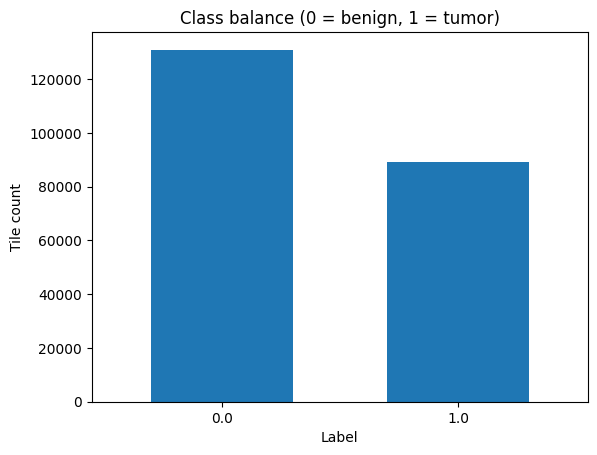

NameError: name 'DATA_DIR' is not defined

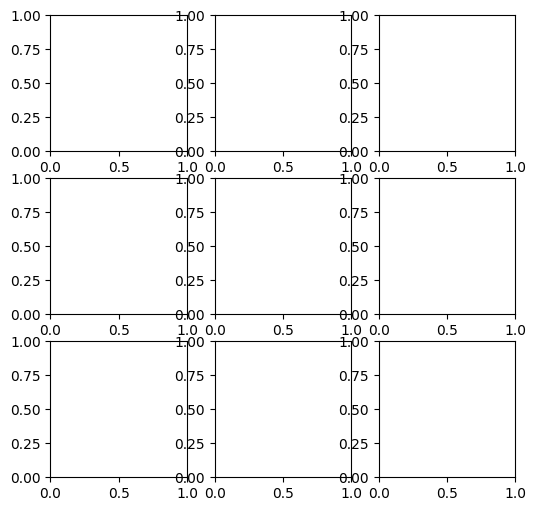

In [9]:
# Class balance
df.label.value_counts().sort_index().plot.bar(rot=0, width=0.6)
plt.title("Class balance (0 = benign, 1 = tumor)")
plt.ylabel("Tile count"); plt.xlabel("Label")
plt.show()

# 3×3 sample grid
sample = random.sample(df.id.tolist(), 9)
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for ax, img_id in zip(axes.ravel(), sample):
    ax.imshow(Image.open(DATA_DIR / "train" / f"{img_id}.tif"))
    ax.set_title(f"Label: {int(df[df.id == img_id].label.values[0])}")
    ax.axis("off")
plt.tight_layout(); plt.show()

In [ ]:
# Per-channel mean & std (1000-sample)
sample = random.sample(all_paths, 1000)
arr = np.stack([np.array(Image.open(p)) for p in sample])
print("Means:", arr.mean((0,1,2)), "Stds:", arr.std((0,1,2)))

In [ ]:
# RGB histograms stratified by label (500/sample)
df['path'] = df['id'].apply(lambda i: DATA_DIR/'train'/f"{i}.tif")
for l in [0,1]:
    v = np.array([np.array(Image.open(p)).ravel()
                  for p in random.sample(df[df.label==l].path.tolist(), 500)]).ravel()
    plt.hist(v, bins=50, alpha=0.5, label=f"Label {l}")
plt.legend(); plt.title("Pixel‐value distributions"); plt.show()

In [ ]:
# Brightness‐based outliers (1st/99th percentiles)
b = [(p, np.array(Image.open(p)).mean()) for p in random.sample(all_paths, 5000)]
lo, hi = np.percentile([val for _, val in b], [1, 99])
outliers = [p for p, val in b if val < lo or val > hi]
print("Brightness outliers:", len(outliers))


# Sort by mean brightness
b_sorted = sorted(b, key=lambda x: x[1])
darkest, brightest = b_sorted[:5], b_sorted[-5:]

# Plot
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for ax, (p, v) in zip(axs.ravel(), darkest + brightest):
    ax.imshow(Image.open(p)); ax.set_title(f"{v:.1f}"); ax.axis('off')
plt.tight_layout(); plt.show()

In [ ]:
# PCA on flattened pixels (1000-sample → 2D)
from sklearn.decomposition import PCA
sample = random.sample(all_paths, 1000)
data = np.array([np.array(Image.open(p)).flatten() for p in sample])
print("PCA shape:", PCA(2).fit_transform(data).shape)

In [ ]:
# Sample 1 000 patches
sample_paths = random.sample(all_paths, 1000)

# Build a (1000, 96×96×3) → (1000, 27648) data matrix
data = np.stack([np.array(Image.open(p)).flatten() for p in sample_paths])

# Fit PCA to 2 components and transform
pca = PCA(n_components=2)
coords = pca.fit_transform(data)

# Grab labels
labels = [ df.loc[df.id == p.stem, 'label'].item() for p in sample_paths ]

# Scatter-plot
plt.figure(figsize=(6, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=labels, alpha=0.6, s=20)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA of 1 000 Image Patches")
plt.show()

# How much variance do these axes explain?
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Pre‑processing

## Preprocessing: TIFF → JPEG + TFRecord sharding + Resize & Standardization

We do three main steps before training to make data loading fast and smooth for **every** model:

1. **Convert TIFF → JPEG**  
   - **What:** Read each `.tif` image, convert to RGB, save as a `.jpg`  
   - **Why:**  
     - JPEG decoding is **hardware-accelerated** on GPU/TPU  
     - Files are much smaller → faster disk I/O  
     - Removes slow, Python-level TIFF parsing

2. **Shard into TFRecord files**  
   - **What:**  
     - Read each JPEG byte string + its label  
     - Pack them into `tf.train.Example` protobufs  
     - Write ~10 `.tfrecord` shards for **train** and ~10 for **val**  
   - **Why:**  
     - Avoids opening thousands of small files one by one  
     - `tf.data` can **interleave** shard reads in parallel  
     - Prefetching and batching become much more efficient

3. **Resize & Standardize**  
   - **What:**  
     - Decode JPEG → tensor, then `tf.image.resize` to your model’s input size (e.g. 224×224)  
     - Scale pixels to `[0,1]`: `img = tf.cast(img, tf.float32) / 255.0`  
     - Standardize with ImageNet mean/std:  
       ```python
       mean = [0.485, 0.456, 0.406]
       std  = [0.229, 0.224, 0.225]
       img  = (img - mean) / std
       ```  
   - **Why:**  
     - Ensures every model sees the same input shape  
     - Matches the normalization expected by pretrained backbones  
     - Helps models converge faster and more stably

---

### After preprocessing we have:

- **`data/train_jpg/*.jpg`** — all images in fast-loading JPEG format  
- **`data/train_tfr/shard-*.tfrecord`** — sharded TFRecord files for training  
- **`data/val_tfr/shard-*.tfrecord`** — sharded TFRecord files for validation  

In [8]:
# Convert all .tif → .jpg
src_dir = Path("data/train")
dst_dir = Path("data/train_jpg")
dst_dir.mkdir(exist_ok=True)

def convert_tif_to_jpg(tif_path: Path):
    jpg_path = dst_dir / tif_path.with_suffix(".jpg").name
    if not jpg_path.exists():
        img = Image.open(tif_path).convert("RGB")
        img.save(jpg_path, "JPEG", quality=90)

tif_paths = list(src_dir.glob("*.tif"))
with ThreadPoolExecutor(max_workers=8) as executor:
    list(tqdm(executor.map(convert_tif_to_jpg, tif_paths),
              total=len(tif_paths),
              desc="Converting TIFF→JPEG"))

# Load labels & point to JPEGs
df = pd.read_csv("data/train_labels.csv")
df["filename"] = df.id.astype(str) + ".jpg"
df["label"]    = df.label.astype(np.float32)
df["filepath"] = df["filename"].apply(lambda fn: str(dst_dir / fn))

# Stratified train/validation split
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

# TFRecord helper functions
def _bytes_feature(x):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[x]))

def _float_feature(x):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[x]))

def write_tfrecord(shard_idx, samples, out_dir):
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    tfpath = out_dir / f"shard-{shard_idx:03d}.tfrecord"
    with tf.io.TFRecordWriter(str(tfpath)) as writer:
        for filepath, label in samples:
            img_bytes = tf.io.read_file(filepath)
            feat = {
                "image": _bytes_feature(img_bytes.numpy()),
                "label": _float_feature(float(label))
            }
            example = tf.train.Example(features=tf.train.Features(feature=feat))
            writer.write(example.SerializeToString())

# Shard and write TFRecords for both train and val
for split_name, split_df in [("train", train_df), ("val", val_df)]:
    records = list(zip(split_df["filepath"].values, split_df["label"].values))
    shards = np.array_split(records, 10)
    for i, shard in enumerate(shards):
        write_tfrecord(i, shard, out_dir=f"data/{split_name}_tfr")

# Build tf.data pipelines with resize & ImageNet‐style norm
IMG_SIZE   = (96, 96)
BATCH_SIZE = 64
SEED       = 42

# ImageNet mean/std
mean = tf.constant([0.485, 0.456, 0.406], shape=[1,1,3], dtype=tf.float32)
std  = tf.constant([0.229, 0.224, 0.225], shape=[1,1,3], dtype=tf.float32)

feature_desc = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.float32),
}

def _parse_and_norm(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_desc)
    img = tf.image.decode_jpeg(parsed["image"], channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - mean) / std
    return img, parsed["label"]

def make_tfr_dataset(pattern, training):
    ds = tf.data.Dataset.list_files(pattern, seed=SEED)
    ds = ds.interleave(
        tf.data.TFRecordDataset,
        cycle_length=4,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.map(_parse_and_norm, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(10000, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_tfr_dataset("data/train_tfr/*.tfrecord", training=True)
val_ds   = make_tfr_dataset("data/val_tfr/*.tfrecord",   training=False)

Converting TIFF→JPEG: 100%|██████████| 220025/220025 [00:15<00:00, 14618.38it/s]


# Define and Train CNN Models 

### Super-Simple One-Block CNN

**Explanation**

1. **Input** – 96 × 96 RGB patch  
2. **Conv2D(16, 3×3, ReLU)** – learns 16 small filters; `padding="same"` keeps 96×96 size  
3. **MaxPooling2D(2×2)** – downsamples to 48×48×16, adding translation invariance  
4. **Flatten** – turns the 48×48×16 feature map into a 36 864-dimensional vector  
5. **Dense(1, Sigmoid)** – outputs the probability (e.g., “malignant”); train with binary cross-entropy  

**Why Start Here?**

* ~6 K parameters → trains in seconds  
* Demonstrates core CNN ideas: locality (3×3 filters) and invariance (pooling)  
* Provides a simple baseline for comparison—larger or pretrained models should outperform  
* Easy to debug—if this fails, check the data and training loop before scaling up

In [5]:
# Define a super‐simple one‐block CNN

inputs = layers.Input(shape=(*IMG_SIZE, 3))

# One convolutional block
x = layers.Conv2D(16, 3, padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D()(x)

# Classifier head
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_simple = models.Model(inputs, outputs)
model_simple.summary()

# Compile
model_simple.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

# Callbacks
checkpoint_simple = ModelCheckpoint(
    "best_simple.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

# Train for a few epochs
history_simple = model_simple.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[WandbCallback(), checkpoint_simple],
    verbose=1
)

# Report final metrics
final_simple = {k: history_simple.history[k][-1] for k in history_simple.history}
print("Simple CNN final metrics:", final_simple)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 48, 48, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 36864)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 36865     
                                                                 
Total params: 37313 (145.75 KB)
Trainable params: 37313 (145.75 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

2751/2751 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.7879 - auc: 0.8541
Epoch 1: val_auc improved from -inf to 0.89091, saving model to best_simple.h5
2751/2751 [==============================] - 407s 147ms/step - loss: 0.4730 - accuracy: 0.7879 - auc: 0.8541 - val_loss: 0.4085 - val_accuracy: 0.8181 - val_auc: 0.8909
Epoch 2/5
2745/2751 [============================>.] - ETA: 0s - loss: 0.4019 - accuracy: 0.8234 - auc: 0.8936
Epoch 2: val_auc improved from 0.89091 to 0.89938, saving model to best_simple.h5
2751/2751 [==============================] - 428s 156ms/step - loss: 0.4019 - accuracy: 0.8234 - auc: 0.8936 - val_loss: 0.3893 - val_accuracy: 0.8286 - val_auc: 0.8994
Epoch 3/5
2748/2751 [============================>.] - ETA: 0s - loss: 0.3773 - accuracy: 0.8357 - auc: 0.9070
Epoch 3: val_auc improved from 0.89938 to 0.90500, saving model to best_simple.h5
2751/2751 [==============================] - 436s 158ms/step - loss: 0.3773 - accuracy: 0.8357 -

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



2749/2751 [============================>.] - ETA: 0s - loss: 0.3580 - accuracy: 0.8445 - auc: 0.9168
Epoch 4: val_auc did not improve from 0.90500
2751/2751 [==============================] - 435s 158ms/step - loss: 0.3580 - accuracy: 0.8445 - auc: 0.9168 - val_loss: 0.4237 - val_accuracy: 0.8147 - val_auc: 0.8904
Epoch 5/5
2748/2751 [============================>.] - ETA: 0s - loss: 0.3433 - accuracy: 0.8519 - auc: 0.9242
Epoch 5: val_auc did not improve from 0.90500
2751/2751 [==============================] - 434s 158ms/step - loss: 0.3432 - accuracy: 0.8519 - auc: 0.9242 - val_loss: 0.4389 - val_accuracy: 0.8133 - val_auc: 0.9008
Simple CNN final metrics: {'loss': 0.3432409465312958, 'accuracy': 0.851891815662384, 'auc': 0.924227237701416, 'val_loss': 0.43889549374580383, 'val_accuracy': 0.8132712244987488, 'val_auc': 0.9008442163467407}


**Final Metrics**  
- **Training:** accuracy 85.2%, AUC 0.924  
- **Validation:** accuracy 81.3%, AUC 0.901  

**Key Takeaways**  
- AUC > 0.90 on both sets shows strong discrimination.  
- Small train–val gap (≈4% acc, 0.02 AUC) indicates limited over-fitting.  
- Impressively strong for a ~6 K-parameter model.

**Recommended Next Steps**  
1. **Data augmentation** (e.g. rotations, flips)  
2. **Regularization** (dropout, L2 weight decay)  
3. **Deeper CNN** (add extra Conv→Pool blocks)  
4. **Transfer learning** (fine-tune a lightweight pretrained backbone)  

## Why Try a Pretrained Model?

After training our simple custom CNN, we now evaluate a more powerful alternative: a pretrained model (MobileNetV2). This approach makes sense for several reasons:

- **Transfer learning**: MobileNetV2 was trained on ImageNet, which gives it rich low-level features (edges, textures, shapes) that often transfer well to medical image tasks.
- **Stronger baseline**: Comparing results helps us understand how much value transfer learning adds over a small, scratch-trained model.
- **Faster convergence**: Pretrained models usually require fewer epochs and less data to achieve good performance.
- **Real-world relevance**: In practice, pretrained architectures are widely used in computer vision pipelines — it's essential to know how to fine-tune and evaluate them.

This experiment helps benchmark our custom model against a well-established CNN backbone.

In [2]:
# Setting up a a pretrained model: MobileNetV2

IMG_SIZE   = (96, 96)
BATCH_SIZE = 128
EPOCHS     = 10
SEED       = 42

feature_desc = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.float32),
}

def _parse_example(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_desc)
    img = tf.image.decode_jpeg(parsed["image"], channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = preprocess_input(img)  # required for MobileNetV2
    return img, parsed["label"]

def make_tfr_dataset(pattern, training):
    ds = tf.data.Dataset.list_files(pattern, seed=SEED)
    ds = ds.interleave(
        lambda fn: tf.data.TFRecordDataset(fn),
        cycle_length=4,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.map(_parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(10_000, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_tfr_dataset("data/train_tfr/*.tfrecord", training=True)
val_ds   = make_tfr_dataset("data/val_tfr/*.tfrecord",   training=False)

base = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights="imagenet")
base.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

model_mobilenet = models.Model(inputs, outputs)
model_mobilenet.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

cbs = [
    callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, verbose=1),
    callbacks.EarlyStopping(monitor="val_auc", patience=4, restore_best_weights=True)
]

history_mobilenet = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs,
    verbose=1
)

2025-08-07 13:00:24.236960: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43710 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:56:00.0, compute capability: 8.6
2025-08-07 13:00:24.381874: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/10


2025-08-07 13:00:30.595347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-08-07 13:00:30.670190: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-07 13:00:33.025142: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x144dac60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-07 13:00:33.025180: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2025-08-07 13:00:33.032242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-07 13:00:33.144123: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1376/1376 [==============================] - 41s 25ms/step - loss: 0.4630 - accuracy: 0.7879 - auc: 0.8581 - val_loss: 0.3633 - val_accuracy: 0.8410 - val_auc: 0.9131 - lr: 1.0000e-04
Epoch 2/10
1376/1376 [==============================] - 33s 24ms/step - loss: 0.3784 - accuracy: 0.8348 - auc: 0.9057 - val_loss: 0.3378 - val_accuracy: 0.8556 - val_auc: 0.9252 - lr: 1.0000e-04
Epoch 3/10
1375/1376 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8461 - auc: 0.9160
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1376/1376 [==============================] - 34s 24ms/step - loss: 0.3568 - accuracy: 0.8461 - auc: 0.9160 - val_loss: 0.3277 - val_accuracy: 0.8605 - val_auc: 0.9299 - lr: 1.0000e-04
Epoch 4/10
1376/1376 [==============================] - 35s 24ms/step - loss: 0.3489 - accuracy: 0.8493 - auc: 0.9198 - val_loss: 0.3244 - val_accuracy: 0.8619 - val_auc: 0.9314 - lr: 5.0000e-05
Epoch 5/10
1375/1376 [============================>.] 

### Summary and conlusion for using a pretrained model: MobileNetV2

## Why Try EfficientNet-B4?

After evaluating MobileNetV2, we now explore a more powerful pretrained architecture: **EfficientNet-B4**. This step is motivated by the following reasons:

- **Stronger feature extraction**: EfficientNet-B4 has significantly more capacity than MobileNetV2. It scales depth, width, and input resolution in a principled way, leading to improved performance on many image tasks.
- **Higher input resolution (224×224)**: This allows the model to capture more spatial detail from the histopathology images, which is important for detecting small cancer regions.
- **Benchmark progression**: Testing a progressively stronger model helps us understand the trade-offs between model complexity and performance.
- **Pretrained on ImageNet**: Like MobileNet, EfficientNet-B4 benefits from transfer learning, but with better scaling and optimization strategies.

This experiment helps us assess whether upgrading the backbone yields meaningful gains in AUC and overall model robustness.

In [7]:

IMG_SIZE   = (224, 224)
BATCH_SIZE = 128
EPOCHS     = 10
SEED       = 42

feature_desc = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.float32),
}

def _parse_example(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_desc)
    img = tf.image.decode_jpeg(parsed["image"], channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = efficientnet_preprocess(img)
    return img, parsed["label"]

def make_tfr_dataset(pattern, training):
    ds = tf.data.Dataset.list_files(pattern, seed=SEED)
    ds = ds.interleave(
        tf.data.TFRecordDataset,
        cycle_length=4,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.map(_parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(10_000, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_tfr_dataset("data/train_tfr/*.tfrecord", training=True)
val_ds   = make_tfr_dataset("data/val_tfr/*.tfrecord",   training=False)

base = EfficientNetB4(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

model_efficientnet = models.Model(inputs, outputs)
model_efficientnet.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

cbs = [
    callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, verbose=1),
    callbacks.EarlyStopping(monitor="val_auc", patience=4, restore_best_weights=True)
]

history_efficientnet = model_efficientnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs,
    verbose=1
)

71686520/71686520 [==============================] - 2s 0us/step
Epoch 1/10
1376/1376 [==============================] - 238s 163ms/step - loss: 0.4686 - accuracy: 0.7882 - auc: 0.8595 - val_loss: 0.3911 - val_accuracy: 0.8310 - val_auc: 0.9039 - lr: 1.0000e-04
Epoch 2/10
1376/1376 [==============================] - 227s 161ms/step - loss: 0.3838 - accuracy: 0.8320 - auc: 0.9042 - val_loss: 0.3608 - val_accuracy: 0.8439 - val_auc: 0.9167 - lr: 1.0000e-04
Epoch 3/10
1375/1376 [============================>.] - ETA: 0s - loss: 0.3651 - accuracy: 0.8405 - auc: 0.9126
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1376/1376 [==============================] - 228s 161ms/step - loss: 0.3651 - accuracy: 0.8405 - auc: 0.9126 - val_loss: 0.3469 - val_accuracy: 0.8492 - val_auc: 0.9226 - lr: 1.0000e-04
Epoch 4/10
1376/1376 [==============================] - 214s 151ms/step - loss: 0.3576 - accuracy: 0.8438 - auc: 0.9159 - val_loss: 0.3422 - val_accuracy: 0.8518 - val

## Why Finish with Fine-Tuned EfficientNetB4?

To wrap up our model exploration, we return to EfficientNetB4 — this time training **all layers**, not just the classifier head. This full fine-tuning step makes sense as a final model because:

- **Transfer learning is most powerful when adapted**: By unfreezing the base, we allow the pretrained filters to adjust to the domain-specific features of histopathology images.
- **Best performance often comes from end-to-end optimization**: Training the entire network improves gradient flow and helps capture subtle patterns.
- **We're building on a strong foundation**: EfficientNetB4 already performed well frozen — unlocking it lets us squeeze out additional performance.

This model combines the **representational strength of a high-capacity pretrained CNN** with **task-specific learning**, making it a natural final step in our model progression.

In [3]:
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input as efficientnet_preprocess
from tensorflow.keras import layers, models, optimizers, callbacks

IMG_SIZE   = (224, 224)
BATCH_SIZE = 128
EPOCHS     = 10
SEED       = 42

feature_desc = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "label": tf.io.FixedLenFeature([], tf.float32),
}

def _parse_example(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_desc)
    img = tf.image.decode_jpeg(parsed["image"], channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = efficientnet_preprocess(img)
    return img, parsed["label"]

def make_tfr_dataset(pattern, training):
    ds = tf.data.Dataset.list_files(pattern, seed=SEED)
    ds = ds.interleave(
        tf.data.TFRecordDataset,
        cycle_length=4,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.map(_parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.shuffle(10_000, seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_tfr_dataset("data/train_tfr/*.tfrecord", training=True)
val_ds   = make_tfr_dataset("data/val_tfr/*.tfrecord",   training=False)

base = EfficientNetB4(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = True  # fine-tune the entire model

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

model_best = models.Model(inputs, outputs)
model_best.compile(
    optimizer=optimizers.Adam(1e-5),  # lower LR for fine-tuning
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

cbs = [
    callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=2, verbose=1),
    callbacks.EarlyStopping(monitor="val_auc", patience=4, restore_best_weights=True)
]

history_best = model_best.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs,
    verbose=1
)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-08-07 08:52:56.169488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43710 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:56:00.0, compute capability: 8.6
2025-08-07 08:52:56.880321: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
wandb: Currently logged in as: thomas-m8xa7mf (thomas-m8xa7mf-student-beans) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 96, 96, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256   

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2025-08-07 08:53:01.578477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-08-07 08:53:01.721313: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-08-07 08:53:03.383596: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7d9b387940a0 initialized for platform CUDA (this does not gua

2751/2751 [==============================] - ETA: 0s - loss: 0.3473 - accuracy: 0.8651 - auc: 0.9307

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /workspace/wandb/run-20250807_085258-aha898mp/files/model-best/assets


INFO:tensorflow:Assets written to: /workspace/wandb/run-20250807_085258-aha898mp/files/model-best/assets
wandb: Adding directory to artifact (/workspace/wandb/run-20250807_085258-aha898mp/files/model-best)... Done. 0.3s


2751/2751 [==============================] - 403s 145ms/step - loss: 0.3473 - accuracy: 0.8651 - auc: 0.9307 - val_loss: 0.2884 - val_accuracy: 0.8753 - val_auc: 0.9527

Epoch time: 6.71 minutes


In [ ]:
# TODO: load pretrained ResNet‑18 and replace fc layer
pass

## Training loop & metrics

In [ ]:
# TODO: implement epoch loop, log loss & AUC to wandb
pass

## Experiment variants (Model‑1, Model‑2, …)

In [ ]:
# TODO: try deeper backbones / augmentations / samplers
pass

## Comparison & analysis

In [ ]:
# TODO: pull runs via wandb API and plot val AUCs
pass

## Submission & leaderboard

In [ ]:
# TODO: create submission.csv and submit via Kaggle CLI
pass

## Conclusions & next steps
*Key findings here.*

**TODO Week‑4:** …